# Minimal KMC Validation

This notebook tests the core KMC probability model against ODEs.
No particles, patches, or fields - just pure binding kinetics.

In [1]:
# Cell 1: Setup
import numpy as np
import matplotlib.pyplot as plt
from src.minimal_kmc import (
    run_minimal_kmc, 
    run_multiple_replicates,
    calculate_statistics,
    compare_kmc_to_ode
)
from src.ode_solver import solve_binding_odes, calculate_equilibrium_fractions
from src.parameters import SimulationParameters

%matplotlib inline

In [2]:
# Cell 2: Define Parameters
print("## Parameters")
print("\nUsing the same values as your full simulation for direct comparison.")

# Create parameters (we'll extract the relevant values)
params = SimulationParameters(
    C_A=0.002,  # nM
    C_B=0.002,  # nM
    C_antigen=0.1,  # nM
    C_enhancement=1.0e-6,
    N_A_sim=50,
    N_B_sim=50,
    antibodies_per_particle=1000,
    n_patches=12,
    kon_a=1.0e5,  # M⁻¹s⁻¹
    koff_a=0.0001,  # s⁻¹
    kon_b=1.0e5,  # M⁻¹s⁻¹
    koff_b=0.0001,  # s⁻¹
    dt=0.1,  # s
    n_steps_on=10,
    n_steps_off=10,
    n_repeats=100,
)

# Extract for minimal KMC
N_antigen = params.N_antigen_sim
C_A = params.C_antibody_A  # Already in M
C_B = params.C_antibody_B  # Already in M
kon_a = params.kon_a
koff_a = params.koff_a
kon_b = params.kon_b
koff_b = params.koff_b
dt = params.dt

print("Parameters:")
print(f"  N_antigen: {N_antigen}")
print(f"  C_A: {C_A:.2e} M")
print(f"  C_B: {C_B:.2e} M")
print(f"  kon: {kon_a:.2e} M⁻¹s⁻¹")
print(f"  koff: {koff_a:.2e} s⁻¹")
print(f"  K_D: {koff_a/kon_a:.2e} M")
print(f"  dt: {dt} s")

## Parameters

Using the same values as your full simulation for direct comparison.
Parameters:
  N_antigen: 2500
  C_A: 2.00e-09 M
  C_B: 2.00e-09 M
  kon: 1.00e+05 M⁻¹s⁻¹
  koff: 1.00e-04 s⁻¹
  K_D: 1.00e-09 M
  dt: 0.1 s


In [3]:
# Cell 3: Run Minimal KMC
print("## Run Minimal KMC")
print("\nRunning multiple replicates to get statistics.")

n_replicates = 10
n_steps = 2000  # 200 seconds

print(f"Running {n_replicates} replicates...")
replicates = run_multiple_replicates(
    n_replicates=n_replicates,
    N_antigen=N_antigen,
    C_A=C_A,
    C_B=C_B,
    kon_a=kon_a,
    koff_a=koff_a,
    kon_b=kon_b,
    koff_b=koff_b,
    dt=dt,
    n_steps=n_steps,
    record_interval=10,
)

kmc_stats = calculate_statistics(replicates)
print("Done!")

## Run Minimal KMC

Running multiple replicates to get statistics.
Running 10 replicates...
Done!


In [4]:
# Cell 4: Solve ODEs
print("## Solve ODEs")

t_span = (0, 200)
t_eval = np.linspace(0, 200, 201)

ode_result = solve_binding_odes(params, t_span, t_eval)

eq = calculate_equilibrium_fractions(params)

print("Equilibrium predictions:")
for state, count in eq['counts'].items():
    frac = eq['fractions'][state]
    print(f"  {state}: {count:.1f} ({frac*100:.1f}%)")

## Solve ODEs
Equilibrium predictions:
  Free: 277.8 (11.1%)
  Bound_A: 555.6 (22.2%)
  Bound_B: 555.6 (22.2%)
  Sandwich: 1111.1 (44.4%)


## Visual Comparison


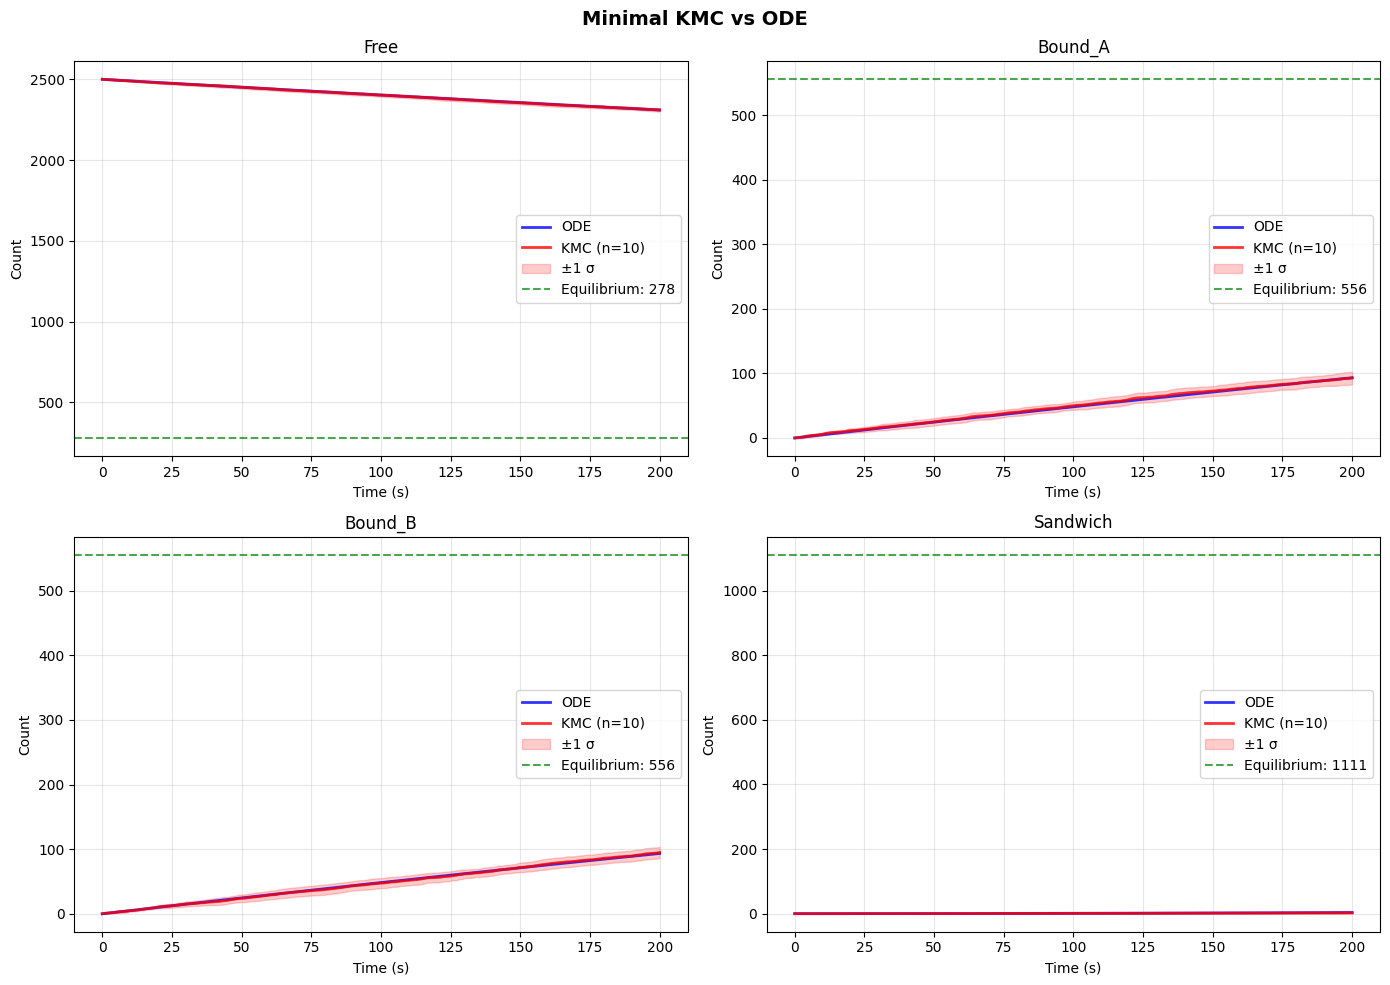

In [5]:
# Cell 5: Plot Comparison
print("## Visual Comparison")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Minimal KMC vs ODE', fontsize=14, fontweight='bold')

states = ['Free', 'Bound_A', 'Bound_B', 'Sandwich']

for ax, state in zip(axes.flat, states):
    # ODE
    ax.plot(ode_result['t'], ode_result[state], 'b-', linewidth=2, 
            label='ODE', alpha=0.8)
    
    # KMC mean with error bars
    kmc_mean = kmc_stats[f'{state}_mean']
    kmc_std = kmc_stats[f'{state}_std']
    ax.plot(kmc_stats['t'], kmc_mean, 'r-', linewidth=2, 
            label=f'KMC (n={n_replicates})', alpha=0.8)
    ax.fill_between(kmc_stats['t'], 
                     kmc_mean - kmc_std, 
                     kmc_mean + kmc_std,
                     color='red', alpha=0.2, label='±1 σ')
    
    # Equilibrium
    eq_count = eq['counts'][state]
    ax.axhline(eq_count, color='green', linestyle='--', linewidth=1.5,
              label=f'Equilibrium: {eq_count:.0f}', alpha=0.7)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Count')
    ax.set_title(state)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Cell 6: Numerical Comparison
print("## Numerical Comparison at t=200s")

comparison = compare_kmc_to_ode(kmc_stats, ode_result, params)

print("\nFinal comparison at t=200s:")
print(f"{'State':<12} {'KMC':<10} {'ODE':<10} {'Ratio':<8} {'Rel Error'}")
print("-" * 55)

for state in ['Free', 'Bound_A', 'Bound_B', 'Sandwich']:
    c = comparison[state]
    print(f"{state:<12} {c['kmc']:>8.1f}  {c['ode']:>8.1f}  {c['ratio']:>6.3f}  {c['rel_error']:>8.1%}")

## Numerical Comparison at t=200s

Final comparison at t=200s:
State        KMC        ODE        Ratio    Rel Error
-------------------------------------------------------
Free           2310.0    2309.6   1.000      0.0%
Bound_A          92.8      93.3   0.995     -0.5%
Bound_B          94.9      93.3   1.017      1.7%
Sandwich          2.3       3.8   0.610    -39.0%


## Test Sensitivity to dt

Smaller dt should give better agreement with ODE.
Testing dt = 0.1 s...
Testing dt = 0.05 s...
Testing dt = 0.01 s...


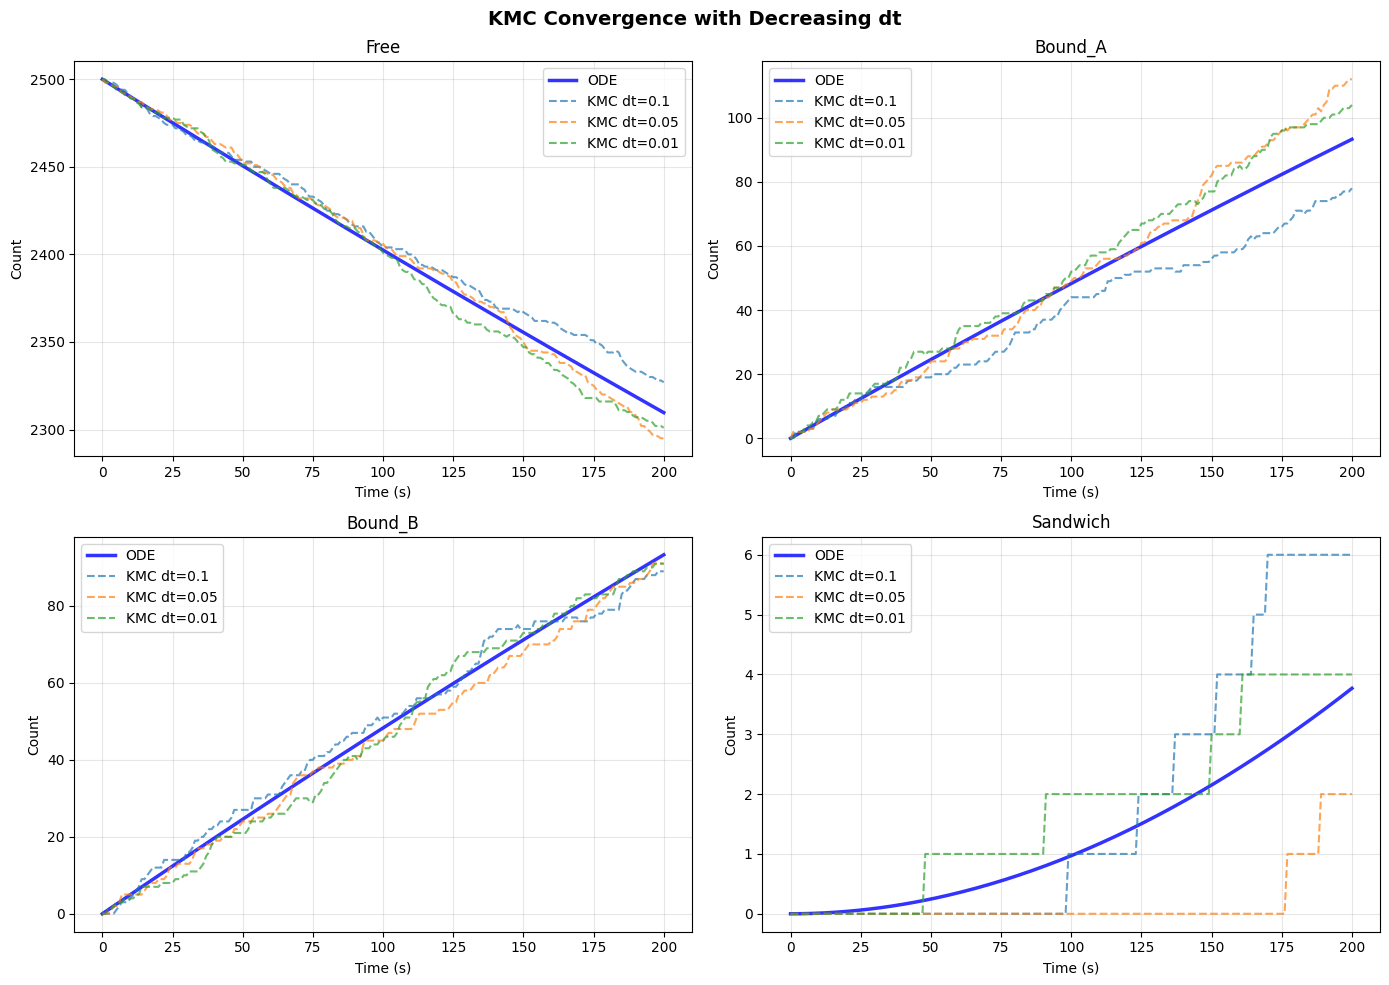

In [7]:
# Cell 7: Test Different Time Steps
print("## Test Sensitivity to dt")
print("\nSmaller dt should give better agreement with ODE.")

dt_values = [0.1, 0.05, 0.01]
results_by_dt = {}

for dt_test in dt_values:
    print(f"Testing dt = {dt_test} s...")
    n_steps_test = int(200 / dt_test)
    
    rep = run_minimal_kmc(
        N_antigen=N_antigen,
        C_A=C_A,
        C_B=C_B,
        kon_a=kon_a,
        koff_a=koff_a,
        kon_b=kon_b,
        koff_b=koff_b,
        dt=dt_test,
        n_steps=n_steps_test,
        record_interval=max(1, n_steps_test // 200),
        seed=42
    )
    results_by_dt[dt_test] = rep

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('KMC Convergence with Decreasing dt', fontsize=14, fontweight='bold')

for ax, state in zip(axes.flat, states):
    ax.plot(ode_result['t'], ode_result[state], 'b-', linewidth=2.5,
            label='ODE', alpha=0.8)
    
    for dt_test in dt_values:
        res = results_by_dt[dt_test]
        ax.plot(res['t'], res[state], '--', linewidth=1.5,
                label=f'KMC dt={dt_test}', alpha=0.7)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Count')
    ax.set_title(state)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Cell 8: Playground
print("## Playground")
print("\nModify parameters and re-run to explore behavior.")

# Try your own parameters here!

## Playground

Modify parameters and re-run to explore behavior.
